In [13]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

An efficient implementation of the Tversky index will be presented in this blog post.

## Motivation


I have been analysing the UK singles charts. The temporal evolution of the record labels was the topic of the [first part of the series](https://bhornung.github.io/python/2019/02/22/uk-charts-1.html). I am now investigating the Christmas singles. In order to determine what fraction of singles released in December recurr in each year, I need a set similiarity measure.


## Set similiarity indices

The number of set similiarity indices is comparable to number of species that ecologists have applied them to. Very much like the species, these indices often known by multiple names. Most of the times, your very own index is the most likely to have been published under three different names by the mid eighties. Look up a review on ecology concerning species diversity or sociology (studies on urban deprivation is a good place to start) and you will find dozens of indices. 

### Requirements

A weekly chart is a set of unique labels. A collection of successive charts is again can be viewed as a chart. The elements, howver, are not necessarily unique. One can create a set of unique elements by selecting each single only once. This, in general, would result in the loss of information on the relative frequency of the singles.

In the following, we restrict our attention to sets, $S_{k}$ which are composed of unique elements:

$$
\begin{eqnarray}
\mathcal{I}_{A} = \{1,...,N_{A} \} \, \quad & \text{(index set of sets)} \\
\forall k \in \mathcal{I}_{A}: A_{k} \neq \emptyset \quad & \text{(sets are not empty)}\\
\forall i,j,\, i \neq j, \, a_{i}, a_{j} \in A_{k} : a_{i} \neq a_{j}  \quad & \text{(sets of unique elements)}
\end{eqnarray}
$$

In the broadest terms, we wish the following behaviour of the index, $d$:

* we wish the limiting values to be 0 and 1. 
    * Zero is returned if the two sets are the least possibly similar
    * One is assumed when the two sets are the most possibly similar
* the index should be symmetric $d(A,B) = d(B,A)$
    
If and only if the two sets have an empty section the index should be zero:

$$
d(A_{i}, A_{j}) = 0 \Leftrightarrow A_{i} \cap A_{j} = \emptyset \quad (1)
$$
    
If and only is one set is a subset of the other the index is unit:

$$
d(A_{i}, A_{j}) = 1 \Leftrightarrow A_{i} \subseteq A_{j} \vee A_{j} \subseteq A_{i} \quad (2) 
$$
    
A handful of standard indices are reviewed below from this perspective.

#### Jaccard index

The popular Jaccard index is the ratio of the cardinalities of the section and union of two sets.

$$
S_{J}(A_{i}, A_{j}) = \frac{|A_{i} \cap A_{j}|}{|A_{i} \cup A_{j}|}
$$

Since the positions of the charts have changed over time the sets (_e.g._ a weekly chart) might have non-equal cardinalities. This index does not fulfil requirement (2).

#### Overlap coefficient

The overlap coefficient is defined as the ratio of the cardinality of the intersection and that of the smaller set:

$$
S_{ol}(A_{i}, A_{j}) = \frac{|A_{i} \cap A_{j}|} {\min(|A_{i}|,|A_{j}|)}
$$

For all $S_{i}$ are not empty this index is defined over all possible pairings. It also meets both criteria.

#### Tversky index

The symmetric Tversky coefficient is given by the following formula:

$$
S_{ts}(A_{i}, A_{j}) = \frac{|A_{i} \cap A_{j}|} { |A_{i} \cap A_{j}| + 
\beta \left(\alpha \min(|A_{i} \setminus A_{j} |,|A_{j} \setminus A_{i}|)  + (1 - \alpha) \max(|A_{i} \setminus A_{j}|,|A_{j} \setminus A_{i}|)   \right)   }
$$

Setting $\alpha = \beta = 1$ returns the overlap coefficient. We choose to implement the Tversky index on the merit of its versatility.

## Implementation

### Aim

We aim to implement a function that calculates the pairwise Tversky indices on a collection of sets.

#### High level algorithm

The algoithm can be broken down to two main components:
* a preprocessing algorithm creates sets from a collection of collection of objects
* the Tversky index is calculated for each pair.

The $\texttt{Tversky}$ function computes the index of a pair of sets.

$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Calculate Tversky index} \\ 
&1. &\textbf{Input:} \, \mathcal{A}, \mathcal{B}: \, \text{sets}; \alpha, \beta \in \left[0,1\right] \\
&2. & \textbf{Output:} \, t \in \left[0,1\right]: \, \text{Tversky index} \\
&3. & \texttt{Tversky}(\mathcal{A}, \mathcal{B}, \alpha, \beta) \\ 
&4. & \quad t = \frac{|\mathcal{A} \cap \mathcal{B}|}
{ |\mathcal{A} \cap \mathcal{B}| + 
\beta \left(\alpha \min(|\mathcal{A} \setminus \mathcal{B} |,|\mathcal{B} \setminus \mathcal{A}|)  + (1 - \alpha) \max(\mathcal{A} \setminus \mathcal{B}|,|\mathcal{B} \setminus \mathcal{A}|)\right)} \\
&5. & \quad \textbf{return} \, t
\end{eqnarray}
$$

The $\texttt{BatchTversky}$ algorithm firstly converts a collection of collections to a collection of sets by sequentially aplying the $\text{Set}$ function. In the second step, the upper diagonal of the index matrix, $\mathbf{T}$ is populated by calling $\texttt{Tversky}$ on the set pairs. The diagonal is then set to unit, as a last step. 

$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Calculate Tversky indices} \\ 
&1. &\textbf{Input:} \, \mathbf{A}: \, \text{list of sets}; \alpha, \beta \in \left[0,1\right] \\
&2. & \textbf{Output:} \, \mathbf{T}: \, \text{coo sparse matrix}, \, \text{pairwise indices} \\
&3. & \texttt{BatchTversky}(\mathbf{A}, \alpha, \beta) \\ 
&4. & \quad T \leftarrow \mathbf{0} \\
&5. & \quad \textbf{for} \, \, A_{i} \,\, \textbf{in} \,\, \mathbf{A} \,\, \textbf{do}\\
&6. & \quad \quad \mathcal{A}_{i} \leftarrow \texttt{set}(A_{i}) \\
&7. & \quad \textbf{for} \, \, i = 1, |\mathcal{A}| \\
&8. & \quad \quad \textbf{for} \, \, j = i+1, |\mathcal{A}| \\
&9. & \quad \quad \quad t_{ij} \leftarrow \texttt{Tversky}(\mathcal{A}_{i}, \mathcal{A}_{j})\\
&10. & \quad \textbf{for} \, \, i = 1, |\mathcal{A}| \\
&11. & \quad \quad t_{ii} = 1 \\
&12. & \quad \textbf{return} \, T
\end{eqnarray} 
$$

Two implementations are given below. One is a high level, native (and rather naive) python manifestation. The other is a low level realisation of the index.

### Native python

The $\texttt{Sets}$ function is implemented as the `convert_to_sets` utility:

In [14]:
def convert_to_sets(collection):
    """
    Converts a collection of objects to a collection of sets
    Parameters:
        collection ([[hashable]]) : a collection of groups of hashable objects
    Returns:
        sets ([{}]) : list of sets
    """
    sets = tuple([set(x) for x in collection])
    
    return sets

The `calculate_tversky_index1` function does what it says on the label:

In [15]:
def calculate_tversky_index1(a1, a2, alpha, beta):
    """
    Calculates the Tversky index between two sets:
    Parameters:
        a1 ({}) : first set
        a2 ({}) : second set
        alpha (float) : alpha parameter
        beta (float) : beta parameter
    Returns:
        tversky_index_ (float) : Tversky index
    """
    n_1 = len(a1)
    n_2 = len(a2)
    n_common = len(a1 & a2)
    
    n_diff12 = n_1 - n_common
    n_diff21 = n_2 - n_common
    
    tversky_index_ = n_common / (n_common + beta * (alpha * min(n_diff12, n_diff21) 
                                            + (1 - alpha) * max(n_diff12, n_diff21))) 
    
    return tversky_index_

The `calculate_set_pairwise_tversky1` consumes a list of sets and returns the array ot indices in coordinate format.

In [16]:
def calculate_set_pairwise_tversky1(sets, alpha = 1, beta = 1):
    """
    Calculates the pairwise Twersky index in a collection of sets.
    Parameters:
        sets (({})) : iterable of sets
        alpha (float) : alpha parameter. Default: 1.
        beta (float) : beta parameter. Default: 1.
    Returns:
        tversky_indices_ (np.ndarray[n_pairs, 3]) : coordinate format dense array of the indices 
    """
    
    if alpha == beta == 0:
        raise ValueError("'alpha' and 'beta' cannot be simultaneously zero.")
    
    n_sets = len(sets)
    
    # set up coo matrix
    n_pairs = int((n_sets + 1) * n_sets / 2)
    tversky_indices_ = np.zeros((n_pairs, 3), dtype = np.float)
    
    # loop over all pairs
    i_cnt = 0
    for i1 in range(n_sets):
        a1 = sets[i1]
        
        for i2 in range(i1 + 1, n_sets):
            a2 = sets[i2]
            
            ti_ = calculate_tversky_index1(a1, a2, alpha, beta)
            tversky_indices_[i_cnt] = i1, i2, ti_
           
            i_cnt += 1
            
    # fill in diagonal
    tversky_indices_[-n_sets:,0] = np.arange(n_sets) 
    tversky_indices_[-n_sets:,1] = np.arange(n_sets)
    tversky_indices_[-n_sets:,2] = 1
    
    return tversky_indices_

Finally all the components are merged together in the function `calculate_pairwise_tversky`

In [17]:
def calculate_pairwise_tversky1(collection, alpha = 1, beta = 1):
    """
    Calculates the pairwise Twersky index in a collection of sets.
    Parameters:
        collection ([[hashable]]) : a collection of groups of hashable objects
        alpha (float) : alpha parameter. Default: 1.
        beta (float) : beta parameter. Default: 1.
    Returns:
        tversky_indices_ (np.ndarray[n_pairs, 3]) : coordinate format dense array of the indices 
    """
    
    if alpha == beta == 0:
        raise ValueError("'alpha' and 'beta' cannot be simultaneously zero.")
    
    sets = convert_to_sets(collection)
        
    tversky_indices_ = calculate_set_pairwise_tversky1(sets, alpha = alpha, beta = beta)
    
    return tversky_indices_

#### Analysis

##### Pros:
* Each function has a clearly defined concern
    * data preprocessing: `convert_to_sets`
    * interface/driver: `calculate_pairwise_tversky1`
    * mathematical unit: `calculate_set_pairwise_tversky1` and `calculate_tversky_index1`
* The function is agnostic to the type of the input data as long as they are hashable
* Simple operations, easy to interpret
* We have recognised that the collections only have to be converted to sets only once
* We have also recognised that the matrix is symmetric, thus the number of operations can be halved

##### Cons:
* For loops are expensive in python
* Does not use any knowledge about the data to speed up calculation
* **Danger**: the diagonal is set to unit without calculating the indices. This might potentially mask errors in the `calculate_tversky_index1` function, for very little speed improvement
* **Annoyance**: the data are copied when the sets are created.
* **Possible improvement**: one can feed generators to the `convert_to_sets` function is the `deque` utility of the `itertools` is invoked. This cn help to avoid copying data.

##### Time complexity

If the average size of a collection is $n$ and there are $N$ collections, the time complexity of the above brute force method is $\mathcal{O}(N^{2} n)$. The hashing requires $\mathcal{O}(Nn)$ operations. Calculating the intersection is proportional to $n \cdot \mathcal{O}(1) = \mathcal{O}(n)$ which has to be done $~N^{2} / 2$ times.

#### Test

This space only allows for simple testing. The input data will be a sequence words.

In [18]:
fruits = ['apple', 'banana', 'cantalopue', 'date', 'elderberry', 'fig', 'grapefruit', 'honeydew melon' ]

# create sets
fruit_bowls = [[fruits[idx] for idx in range(i1, i1 + 4)] for i1 in range(5)]
for idx, bowl in enumerate(fruit_bowls):
    print("{0}. bowl: {1}".format(idx + 1, ", ".join(bowl)))

1. bowl: apple, banana, cantalopue, date
2. bowl: banana, cantalopue, date, elderberry
3. bowl: cantalopue, date, elderberry, fig
4. bowl: date, elderberry, fig, grapefruit
5. bowl: elderberry, fig, grapefruit, honeydew melon


The overlap between the sets are then calculated:

In [19]:
overlap = calculate_pairwise_tversky1(fruit_bowls, alpha = 1, beta = 1)

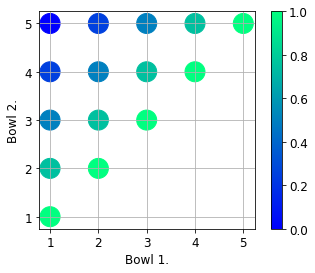

In [20]:
# TO SKIP -- plot setup

fig, ax = plt.subplots(1, 1)
cmap = plt.get_cmap('winter')
img = ax.scatter(overlap[:,0], overlap[:,1], c = overlap[:,2], cmap = cmap, s = 400)
ax.grid(True)
ax.set_xlabel("Bowl 1."); ax.set_ylabel("Bowl 2.")
ax.set_xticks([0,1,2,3,4]); ax.set_xticklabels([str(int(x+1)) for x in ax.get_xticks()])
ax.set_yticks([0,1,2,3,4]); ax.set_yticklabels([str(int(x+1)) for x in ax.get_yticks()])
ax.set_aspect(1)
fig.colorbar(img)
plt.show()

It looks as expected. The first and last sets do not have common elements, hence their overlap is zero.

### Low level implementation

No matter how versatily the above implementation is it has a number of serious shortcomings. We will try to address and resolve some of them in this section.

#### General considerations

##### Possible improvements

The time complexity of the naive algorithm is $\mathcal{O}(N^{2}n)$. $N^{2}$ is number of comparisions, and $n$ is the time needed to compare two elements. Either of them is reduced, the algorithm speeds up. It is unlikely that the hash lookup can be improved upon, thus we will concentrate on the reducing the $N^{2}$ number of comparisons.

#### Totally ordered sets

Let us assume the collections are totally ordered sets, it is therefore possible to find the their minimum and maximum elements. Is it a good assumption? It is more than likely that the collections will consists of integer hashes in production environment. Therefore the elements in a collection can be ordered. If the sets do no consist of integers one can always hash the elements, assuming a good hash function in $\mathcal{O}(Nn)$ time.

Once the least and largest elements of all sets a determined, the sets can be screened for comparison. If the least element of a set is greater than the maximum of the other, their intersection is zero.

The steps are now assuming totally ordered sets:
* sort all sets: $\mathcal{O}(Nn\log n)$
* find least and maximum elements: $\mathcal{O}(N)$
* sort least and maximum elements: $\mathcal{O}(N \log N)$
* compare  bounding elements using binary search: $\mathcal{O}(N \log N)$
* determine intersections: $\mathcal{O}(N^{2}n)$

As we can see the average time complexity is the same, only a $\mathcal{O}(Nn\log n)$ term has been added. In realistic cases ($n >> 4$) this is a negligible burden. However, depending on the distribution of elements _e.g._ the average set size is much smaller than the number of hashes, and the sets tend to have elements from the same neighbourhood, it can result in considerable speed up.

#### Algorithm

The bulletpoints above serve as guide to write the algorithm $\texttt{ScreenBatchTversky}$ which screens the sets for non-zero intersections.

$$
\begin{eqnarray}
& & \textbf{Algorithm:} \, \textit{Calculate Tversky indices with screening} \\ 
&1. &\textbf{Input:} \, \mathbf{A}: \, \text{list of totally ordered sets}; \alpha, \beta \in \left[0,1\right] \\
&2. & \textbf{Output:} \, \mathbf{T}: \, \text{coo sparse matrix} \, \text{pairwise indices} \\
&3. & \texttt{ScreenBatchTversky}(\mathbf{A}, \alpha, \beta) \\ 
%
&4. & \quad \mathbf{T} \leftarrow \mathbf{0} \\
&5. & \quad \mathbf{L} \leftarrow \mathbf{0} \\
&6. & \quad \mathbf{U} \leftarrow \mathbf{0} \\
&7. & \quad \mathbf{C} \leftarrow \mathbf{0} \\
%
&8. & \quad \textbf{for} \, \, \mathcal{A}_{i} \,\, \textbf{in} \,\, \mathbf{A} \,\, \textbf{do}\\
&9. & \quad \quad \mathcal{A}_{i} \leftarrow \texttt{sort}(\mathcal{A}_{i}) \\
%
&10. & \quad \textbf{for} \, \, i = 1, |\mathbf{A}| \,\, \textbf{do}\\
&11. & \quad \quad L_{i} \leftarrow \text{inf}(\mathcal{A}_{i}) \\
&12. & \quad \quad U_{i} \leftarrow \sup(\mathcal{A}_{i}) \\
%
&13. & \quad \mathbf{L} \leftarrow \texttt{sort}(\mathbf{L}) \\
&14. & \quad \mathbf{U} \leftarrow \texttt{sort}(\mathbf{U}) \\
%
&15. & \quad  \textbf{for} \, \, i = 1, |\mathbf{A}| \,\, \textbf{do}\\
&16. & \quad \quad C_{i} \leftarrow \texttt{SelectNonzeroOverlaps}(L_{i}, \mathbf{U}) \\
%
&17. & \quad \textbf{for} \, \, i = 1, |\mathbf{A}| \,\, \textbf{do}\\
&18. & \quad \quad \textbf{for} \, \, j \in C_{i} \,\, \textbf{do}\\
&19. & \quad \quad \quad T_{ij} \leftarrow \texttt{Tversky}(\mathcal{A}_{i}, \mathcal{A}_{j}) \\
&20. & \quad \textbf{return} \, \mathbf{T}
\end{eqnarray}
$$

The function $\texttt{SelectNonzeroOverlaps}$ compares the least and maximum elements of sets to determine the pairs which definitely do not have intersections. (A note, without looking at the elements of two sets it is not possible to determine whether their intersection is empty, even if their ranges overlap. Consider $\mathcal{A} =\{1,3,5\}$ and $\mathcal{B} = {2,4,6}$. The ranges overlap, but the intersection is empty. In other words, the screening filters out the true negatives, but retains the false positives.

##### Issues
There are four additional issues with the algorithm above.

* Each pair is encountered twice. **Fix**: skip \texttt{Tversky} if $i<j$
* Explicitly storing the selected sets on average require a construction of an $N\times N$ array. **Fix**: store only the first index in an array that sorts $\mathbf{U}$
* A merging the left and right excluded sets requires $N^{2}\log N$ operations. It is still not the end of the world, but we would like to keep the additional operations as low as possible.
* A more subtle danger is that the collection of excluded sets are not symmetric. The larger least element a set has, the more excluded sets it is expected to have.

##### Resolution
These issues can all be solved by introducing some simple modifications.

1.  $\texttt{argsort}$ $U, L$
2. $\texttt{SelectNonzeroOverlaps}$ returns a list of indices, one for each set. Each index contains the lowest position in the sorting index array of $U$
3. Loop over sets starting at the largest least element. 
4. For each set loop over selection
5. Skip if first set index greater than the second

The modified algorithm can be found below

$$
\begin{eqnarray}
& & \textbf{Algorithm:} \, \textit{Calculate Tversky indices with screening} \\ 
&1. &\textbf{Input:} \, \mathbf{A}: \, \text{list of totally ordered sets}; \alpha, \beta \in \left[0,1\right] \\
&2. & \textbf{Output:} \, \mathbf{T}: \, \text{coo sparse matrix} \, \text{pairwise indices} \\
&3. & \texttt{ScreenBatchTversky}(\mathbf{A}, \alpha, \beta) \\ 
%
&4. & \quad \mathbf{T} \leftarrow \mathbf{0} \\
&5. & \quad \mathbf{L} \leftarrow \mathbf{0} \qquad \qquad \textit{(least elements)}\\
&6. & \quad \mathbf{U} \leftarrow \mathbf{0} \qquad \qquad \textit{(largest elements)}\\
&7. & \quad \mathbf{I}_{S} \leftarrow \mathbf{0} \qquad \qquad \textit{(array storing non-excluded sets)}\\
&8. & \quad \mathbf{I}_{B} \leftarrow \mathbf{0} \qquad \qquad \textit{(lookup for least elements)}\\
%
&9. & \quad \textbf{for} \, \, A_{i} \,\, \textbf{in} \,\, \mathbf{A} \,\, \textbf{do}\\
&10. & \quad \quad \mathcal{A}_{i} \leftarrow \texttt{sort}(\mathcal{A}_{i}) \\
%
&11. & \quad \textbf{for} \, \, i = 1, |\mathbf{A}| \,\, \textbf{do}\\
&12. & \quad \quad L_{i} \leftarrow \text{inf}(\mathcal{A}_{i}) \\
&13. & \quad \quad U_{i} \leftarrow \sup(\mathcal{A}_{i}) \\
%
&14. & \quad \mathbf{I}_{L} \leftarrow \texttt{argsort}(\mathbf{L}) \\
&15. & \quad \mathbf{I}_{U} \leftarrow \texttt{argsort}(\mathbf{U}) \\
&16. & \quad \mathbf{I}_{B} \leftarrow \texttt{CreateLookUp}(\mathbf{I}_{L}) \\
%
&17. & \quad \mathbf{I}_{S}\leftarrow \texttt{LeftExcludeSets}(\mathbf{L}, \mathbf{U}, \mathbf{I}_{L}, \mathbf{I}_{U}, \mathbf{I}_{B}) \\
%
&18. & \quad \textbf{for} \, \, k =|\mathbf{A}|, 1, -1 \,\, \textbf{do}\\
&19. & \quad \quad i = I_{L}(k) 
\qquad \qquad \qquad \textit{(choose set with largest least element)} \\
&20. & \quad \quad \textbf{for} \, \, l = \mathbf{I}_{S}(i), \, |\mathbf{I}_{U}| \, \,\textbf{do}
\qquad   \textit{(iterate over non-excluded sets)} \\
&21. & \qquad  \quad j = \mathbf{I}_{U}(l) 
\qquad  \qquad \qquad \textit{(choose the other set)}\\
&22. & \qquad  \quad \textbf{if} \,\, i = j \\
&23. & \qquad \qquad  \textbf{continue} \\
&24. & \quad \qquad  \textbf{if} \,\, k < I_{B}(j) 
\qquad \qquad \qquad \textit{(do not calculate twice)} \\
&25. & \qquad \qquad  \textbf{continue} \\
&26. & \quad \quad \quad T_{ij} \leftarrow \texttt{Tversky}(\mathcal{A}_{i}, \mathcal{A}_{j}) \\
&27. & \quad \textbf{return} \, \mathbf{T}
\end{eqnarray}
$$

A graphical summary of the algorithm helps to explain role of screening
* Each bracket represents a set
    * red is the active set
    * black is a set which can overlap with the active set
    * grey sets cannot overlap with the active one
    * dashed sets are spent and excluded from further comparisons
* The iterations starts with the set which has the largest least element
* Any set that cannot have an overlap with the active set is not used
* The overlap with the sests that potetially overlap with the active one are processed
* Once the all potential sets are iterated over, the active set is block from any further comparison

The $\texttt{}$ algorithm is implemented in the `calculate_pariwise_tersky2` function below. The input `collection` is expected to be a list of `nd.array`-s

In [21]:
nb_int32 = nb.types.int32
nb_f64  = nb.types.float64
nb_omt = nb.types.Omitted

In [22]:
 @nb.jit(
         nb_f64[:,:](
                        nb.types.List(nb_int32[::1], reflected = True), 
                        nb_f64, 
                        nb_f64
                      ), 
         nopython = True,
         debug = True
        )
def calculate_pairwise_tversky2(collection, alpha, beta):
    """
    Calculates the pairwise Twersky index in a collection of sets.
    Parameters:
        collection ([np.ndarray]) : a collection of groups of hashable objects
        alpha (float) : alpha parameter. Default: 1.
        beta (float) : beta parameter. Default: 1.
    Returns:
        tversky_indices_ (np.ndarray[n_pairs, 3]) : coordinate format dense array of the indices  
    """
    
    n_sets = len(collection)
    
    # sort sets in place
    for x in collection:
        x.sort()   
      
     # find minimum and maximum elements
    l_arr = np.array([x[0] for x in collection])
    u_arr = np.array([x[-1] for x in collection])
        
    # argsort
    idcs_l = np.argsort(l_arr)
    idcs_u = np.argsort(u_arr)

    # create lookup
    idcs_b = np.argsort(idcs_l)
    
    # determine which sets to be included (LeftExcludeSets)
    idcs_s = np.searchsorted(u_arr[idcs_u], l_arr[idcs_l])[idcs_b]    
    
    # collects i,j, S_{Tversky}(i,j) triplets
    collector = []
   
    # master loop over sets -- it feels like fortran! 
    for k in range(n_sets -1, -1, -1):
        i = idcs_l[k]
                
        for l in range(idcs_s[i], n_sets):
            j = idcs_u[l]
            
            if i == j:
                continue
                
            if k < idcs_b[j]:
                continue
                            
            ti_ = calculate_tversky_index_sorted(collection[i], collection[j], alpha, beta)
            collector.append((i * 1.0, j * 1.0, ti_))
    
    # add diagonal
    collector.extend([(i, i, 1) for i in range(n_sets)])
            
    # convert to numpy array
    tversky_indices_ = np.array(collector, dtype = np.float64)
    
    return tversky_indices_

The only task to be tackled is to provide a recipe to calculate the index itself. In `calculate_pairwise_tversky1` we used hash tables. Should we invoke this method again, it would result in copying all data $N$ times. Instead, we exploit the fact the arrays are ordered. All equal elements in two sorted arrays of lengths, $m,n$ can be determined in $\mathcal{O}(\min(m,n)$ time without creating any temporary arrays. The algorithm is omitted for sake of brevity this time. The implementation in ` calculate_intersection_size` should be clear enough. Please note, `np.intersect1d` function creates a temporary array, thus we avoid using it.

In [23]:
@nb.jit(
        nb_int32(
                  nb_int32[::1],
                  nb_int32[::1]
                ), 
        nopython = True
       )
def calculate_intersection_size(a1, a2):
    """
    Calculates the size of intersection of two arrays.
    Parameters:
        a1 (np.ndarray 1D) : first array
        a2 (np.ndarray 1D) : second array
    Returns:
        n_common (int) : number of shared elements
    """
    
    # choose sorter array
    # these are pointers, so we do not create new arrays
    
    if a1.size <= a2.size:
        a, b = a1, a2
    else:
        a, b = a2, a1
    
    n_a, n_b = a.size, b.size
    
    # initialise counter
    i, j, n_common = 0, 0, 0
    c_old = min(a[0], b[0]) - 1 # this is dirty, I know
    
    # merge in shorter array, shortcut on disjoint arrays
    while (i < n_a) and (j < n_b):
        
        if a[i] <= b[j]:
            c_new = a[i]
            i += 1
        else:
            c_new = b[j]
            j += 1
            
        if c_new == c_old:
            n_common += 1
       
        c_old = c_new
        
    # compare last element
    if i == n_b:
        if a[-1] == b[j]:
            n_common += 1
    
    if j == n_b:
        if a[i] == b[-1]:
            n_common += 1
        
    return n_common

This method is then wrapped in the `calculate_tversky_index_sorted` function which is called from the main algorithm.

In [24]:
@nb.jit(
        nb_f64(
                nb_int32[::1],
                nb_int32[::1],
                nb_f64,
                nb_f64
              ),
        nopython = True
        )
def calculate_tversky_index_sorted(a1, a2, alpha, beta):
    """
    Calculates the Tversky index of two sorted lists/arrays.
    Parameters:
        a1 (np.ndarray of int) : first array
        a2 (np.ndarray of int) : second array
        alpha (float) : alpha parameter. 
        beta (float) : beta parameter. 
    """
    
    # cardinalities
    n_1 = a1.size
    n_2 = a2.size
    
    # intersection size
    n_common = calculate_intersection_size(a1, a2)

    # 
    n_diff12 = n_1 - n_common
    n_diff21 = n_2 - n_common
    
    tversky_index_ = n_common / (n_common + beta * (alpha * min(n_diff12, n_diff21) 
                                            + (1 - alpha) * max(n_diff12, n_diff21)))
    
    return tversky_index_

#### Analysis

##### Pros:

* The information on the data is exploited to speed up the calculations
* The functions are separated according to their concerns
* The low level functions are compiled which mitigates the cost of the for loops
* The data is not copied

##### Cons:

* The implemenation is rather lenghty
* We relied on just-in-time compilers to speed up the routine
* The type of the input is restricted to numpy arrays, whose element must support direct comparison.
* The input data is modified (_i.e._ sorted)

##### Hints for compiling with `numba`

* Debug the code without `jitting` at first, for buggy code with numba can lead to unaxpected and inconsistent behaviour.
* Always add signature to the `jit` decorator
* When dealing with lists, and the list is modified, add `reflected = True` to the list type definition.
* The default `numba` array layout is `A` which can lead to conflict with `np`-s default `C` layout (it seems like a bug to me). Define the layout as C in the signature by setting `nb_int32[::1]`.
* Do not forget to add `nopython = True` option to the decorator, or use the `njit` decorator.

#### Testing

For sake of brevity, the test set will only consists of a handful of arrays. 

In [25]:
nums = [5,4,7,2,0,1,3,6]
arrs = [np.arange(idx, idx + 4, dtype = np.int32) for idx in nums]

# reference  
tversky_ref_res = calculate_pairwise_tversky1(arrs, 1.0, 1.0) 
  
# sparse + numba
tversky_nb_res = calculate_pairwise_tversky2(arrs, 1.0, 1.0)

The lower triangle of the image below shows the overlap calculated with the `calculate_pairwise_tersky1` algorithm, whilst the upper triangle contains the results from the new algorithm. The two results agree. The zero overlap pairs have been omitted by the new algorithm as expected.

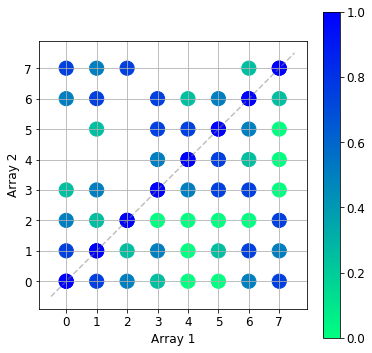

In [26]:
# TO SKIP -- plot setup

fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 6)

cmap = plt.get_cmap('winter_r')

x = np.where(tversky_nb_res[:,0] < tversky_nb_res[:,1], tversky_nb_res[:,0], tversky_nb_res[:,1])
y = np.where(tversky_nb_res[:,0] > tversky_nb_res[:,1], tversky_nb_res[:,0], tversky_nb_res[:,1])

img = ax.scatter(x, y, c = tversky_nb_res[:,2], 
                  cmap = cmap, s = 200, marker = 'o', vmin = 0)

ax.scatter(tversky_ref_res[:,1], tversky_ref_res[:,0], c = tversky_ref_res[:,2], 
                cmap = cmap, s = 200, marker = 'o', vmin = 0)

ax.set_aspect(1)
ax.grid(True)
ax.set_xticks([0,1,2,3,4,5,6,7]); ax.set_yticks([0,1,2,3,4,5,6,7])
ax.set_xlabel("Array 1"); ax.set_ylabel("Array 2")
ax.plot([-0.5, 7.5], [-0.5, 7.5], c = 'grey', alpha = 0.5, linestyle = '--')

fig.colorbar(img)
plt.show()

### Low level implementation 2

We will see that low level implementation is surprisingly slow.  We went a great length to ensure, the for loops are only entered when there is likely to be an overlap, an all known zero overlaps are omitted. The reason being there are numerous array lookup operations. See lines **18-22** in `calculate_pariwise_tversky2`. 

* A possible way to improve the algorithm is to sort the collection according to the minima of the arrays and iterate directly over them.
* One can also implement a binary search in the `calculate_intersection_size` function which would cut down the number of comparisons.

Now matter how enchanting these prospects of rewriting our code again are, we choose to take a different route of action. All lookup arrays will now be omitted. The screening will happen inside the nested for loop. It will result in many empty loop entries, but the memory lookup will be as efficient as possible.

$$
\begin{eqnarray}
& & \textbf{Algorithm:} \, \textit{Calculate Tversky indices with screening} \\ 
&1. &\textbf{Input:} \, \mathbf{A}: \, \text{list of totally ordered sets}; \alpha, \beta \in \left[0,1\right] \\
&2. & \textbf{Output:} \, \mathbf{T}: \, \text{coo sparse matrix} \, \text{pairwise indices} \\
&3. & \texttt{ScreenBatchTverskySlim}(\mathbf{A}, \alpha, \beta) \\ 
%
&4. & \quad \mathbf{T} \leftarrow \mathbf{0} \\
%
&5. & \quad \textbf{for} \, \, A_{i} \,\, \textbf{in} \,\, \mathbf{A} \,\, \textbf{do}\\
&6. & \qquad \mathcal{A}_{i} \leftarrow \texttt{sort}(\mathcal{A}_{i}) \\
%
&7. & \qquad  \textbf{for} \, \, i = 1, \, |\mathbf{A}| \, \,\textbf{do} \\
&8. & \qquad \quad \textbf{for} \, \, j = i + 1, \, |\mathbf{A}| \, \,\textbf{do} \\
%
&9. & \qquad \qquad \textbf{if} \, \, \sup(\mathcal{A}_{i}) < \text{inf}(\mathcal{A}_{j}) \\
&10. & \qquad \qquad \quad \textbf{continue} \\
&11. & \qquad \qquad \textbf{if} \, \, \text{inf}(\mathcal{A}_{i}) > \sup(\mathcal{A}_{j}) \\
&12. & \qquad \qquad \quad \textbf{continue} \\
&13. & \quad \quad \quad T_{ij} \leftarrow \texttt{Tversky}(\mathcal{A}_{i}, \mathcal{A}_{j}) \\
&14. & \quad \textbf{return} \, \mathbf{T}
\end{eqnarray}
$$

This algoritm is implemented in the `calculate_pairwise_tversky3` function below.

In [27]:
 @nb.jit(
         nb_f64[:,:](
                        nb.types.List(nb_int32[::1], reflected = True), 
                        nb_f64, 
                        nb_f64
                      ), 
         nopython = True,
         debug = True
        )
def calculate_pairwise_tversky3(collection, alpha, beta):
    """
    Calculates the pairwise Twersky index in a collection of sets.
    Parameters:
        collection ([np.ndarray]) : a collection of groups of hashable objects
        alpha (float) : alpha parameter. Default: 1.
        beta (float) : beta parameter. Default: 1.
    Returns:
        tversky_indices_ (np.ndarray[n_pairs, 3]) : coordinate format dense array of the indices  
    """
    
    n_sets = len(collection)
    
    # sort sets in place
    for x in collection:
        x.sort()   
      
    collector = []
    # master loop over sets -- it feels like fortran! 
    for i, coll1 in enumerate(collection):
                
        for j, coll2 in enumerate(collection[idx:]):
            
            if (coll1[0] > coll2[-1]) or (coll1[-1] > coll2[0]):
                continue
                            
            ti_ = calculate_tversky_index_sorted(coll1, coll2, alpha, beta)
            collector.append((i * 1.0, j + i * 1.0, ti_))
    
    # add diagonal
    collector.extend([(i, i, 1) for i in range(n_sets)])
            
    # convert to numpy array
    tversky_indices_ = np.array(collector, dtype = np.float64)
    
    return tversky_indices_

## Performance

The performance of the three implementations are now compared. Various sets of arrays are created the following properties of them will be controlled:
* number of arrays: $N$, `n_arr`
* average length of arrays: $n$, `n_size`
* size of the pool of arrays is $10\cdot n$ from which the arrays sampled
* each array contain unique elements

The parameters are as follow:

In [28]:
from sklearn.model_selection import ParameterGrid

test_params = {
                'n_arr' : [100, 500, 1000, 2000],
                'n_size' : [10, 100, 1000]
                }

test_grid = ParameterGrid(test_params)

In order to be a fair comparison, the time needed to convert the arrays to sets will not be measured when the `calculate_pairwise_tersky1` algorithm is used.

The timing results are collected in the `results` list of dictionaries. We use the [`SlimTimer` utility](https://github.com/bhornung/SlimTimer) with which three measurements are carried out. The lines which perform the measurements are omitted from this post for sake of brevity. They can be inspected in the [raw notebook]().

In [29]:
# TO SKIP -- boring

import sys
sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\SlimTimer\source')
from slimTimer import SlimTimer

In [30]:
# TO SKIP -- boring

results = []

for params in test_grid:
    
    arrs = [np.random.choice(params['n_size'] * 10, params['n_size'], replace = False) 
                    for idx in range(params['n_arr'])]
    
    # convert to sets
    arrss = [set(x) for x in arrs]
    
    res = {}
    timer = SlimTimer(func = calculate_pairwise_tversky1, n_runs = 3, tag = 'native')
    timer.set_func_args(arrss, 1.0, 1.0)
    timer.measure()
    res.update(timer.to_dict(with_tag = True))
    del arrss
    
    timer = SlimTimer(func = calculate_pairwise_tversky2, n_runs = 3, tag = 'low-level1')
    timer.set_func_args(arrs, 1.0, 1.0)
    timer.measure()
    res.update(timer.to_dict(with_tag = True))
    
    timer = SlimTimer(func = calculate_pairwise_tversky3, n_runs = 3, tag = 'low-level2')
    timer.set_func_args(arrs, 1.0, 1.0)
    timer.measure()
    res.update(timer.to_dict(with_tag = True))
    
    del arrs
    
    res.update(params)
    results.append(res)

Just to remind ourselves, the expected time compexity is $\mathcal{O}(N^{2}n)$. A set of grey dashed grey lines are overlaid on the panels, each corresponds to quadratic function os the number of arrays.

* the native implementation is the slowest
* all three implementations show quadratic time complexity
* the brute force loop skipping algorithm is the fastest algorithm. 
    * It is 20--50 times faster than the naive implementation and 
    * 5--10 times faster than the "optimised", `calculate_pairwise_tversky2` one.

In [31]:
# TO SKIP -- plot setup

import pandas as pd
res_df = pd.DataFrame(results)

In [32]:
# TO SKIP -- boring

res_df.drop(columns = [
                        'low-level1_runtimes', 
                        'low-level2_runtimes',
                        'native_runtimes'
                        ], 
            inplace = True)

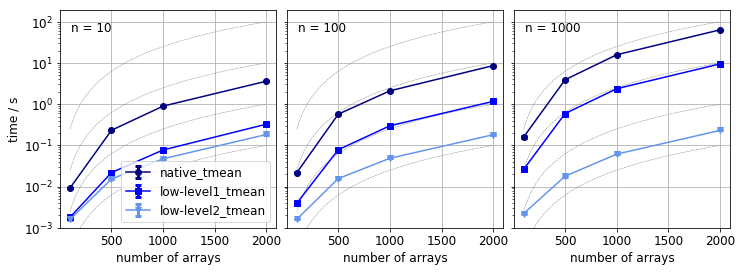

In [33]:
# TO SKIP -- boring

fig, axes = plt.subplots(1, 3, sharex = True, sharey = True,
                         gridspec_kw = {'hspace' : 0.05, 'wspace' : 0.05})
fig.set_size_inches(12, 4)

plot_kwargs = {'capsize' : 3, 'elinewidth' : 3, 'capthick' : 3}

groups = res_df.groupby(['n_size'])
for ax, (n, g) in zip(axes.flat, groups):
    
    ax.errorbar(g['n_arr'], g['native_tmean'], yerr = g['native_tstdev'], 
                c= 'navy', marker = 'o', **plot_kwargs)
    ax.errorbar(g['n_arr'], g['low-level1_tmean'], yerr = g['low-level1_tstdev'], 
                c = 'blue', marker = 's', **plot_kwargs)
    ax.errorbar(g['n_arr'], g['low-level2_tmean'], yerr = g['low-level2_tstdev'], 
                c ='cornflowerblue', marker = 'v', **plot_kwargs)
    
    # add quadratic grid
    x_q = np.arange(100, 1990); y_q = x_q * x_q / 40000; f_qs = [1, 10, 100, 1000]
    for f_q in f_qs:
        ax.plot(x_q, y_q / f_q, c = 'grey', linewidth = 0.5, linestyle = '--')
    
    # decorate plot
    ax.grid(True); ax.set_yscale('log'); ax.set_ylim(0.001)
    subplot_title = r'n = {0}'.format(n)
    ax.text(0.05, 0.95, subplot_title, verticalalignment = 'top', transform=ax.transAxes)
    
    
# decorate axes
for ax in axes:
    ax.set_xlabel("number of arrays")
    
axes[0].set_ylabel("time / s")
    
axes[0].legend(loc = 4)
plt.show()

Does screening for non overlapping arrays improve the performance? It is hard to answer this question, because the difference between the first and the other implementations is twofold: i) the algorithm is different, ii) jit-ing was used to speed up loops. In either case, the `calculate_pairwise_tversky3` is definitely much faster then other two methods. 

What we do know that is the arrays are sampled uniformly from an interval, the size of the average overlap should be independent of the array size and the size of the pool, provided their ratio is constant. If the pool size much larger than the size of the array, the overlap becomes independent of the array size.

To determine the effect of the loop optimisation two algorithms are compared. One is the `calculate_pairwise_tversky3`, the other is nearly identical to the first one, save for the screening for non-overlapping arrays has been removed.

If the array elements are not sampled uniformly, the effect of screening is amplified. A series of test are carried out on the following two-layer sampling distribution.

* a pool of consecutive integers from 0 to 100,000 is created. 
* from this pool intervals of length of 500 are uniformly sampled with replacement
* from each interval an array of length of 100 is sampled without replacement
* the number of arrays varies between 100 and 4000.

In [34]:
# TO SKIP -- boring

@nb.jit(
         nb_f64[:,:](
                        nb.types.List(nb_int32[::1], reflected = True), 
                        nb_f64, 
                        nb_f64
                      ), 
         nopython = True,
         debug = True
        )
def calculate_pairwise_tversky4(collection, alpha, beta):
    """
    Calculates the pairwise Twersky index in a collection of sets.
    Parameters:
        collection ([np.ndarray]) : a collection of groups of hashable objects
        alpha (float) : alpha parameter. Default: 1.
        beta (float) : beta parameter. Default: 1.
    Returns:
        tversky_indices_ (np.ndarray[n_pairs, 3]) : coordinate format dense array of the indices  
    """
    
    n_sets = len(collection)
    
    # sort sets in place
    for x in collection:
        x.sort()   
      
    collector = []
    # master loop over sets -- it feels like fortran! 
    for i, coll1 in enumerate(collection):
                
        for j, coll2 in enumerate(collection[idx:]):
                            
            ti_ = calculate_tversky_index_sorted(coll1, coll2, alpha, beta)
            collector.append((i * 1.0, j + i * 1.0, ti_))
    
    # add diagonal
    collector.extend([(i, i, 1) for i in range(n_sets)])
            
    # convert to numpy array
    tversky_indices_ = np.array(collector, dtype = np.float64)
    
    return tversky_indices_

In [35]:
# TO SKIP -- boring

n_pool_size = 100000
n_arrs = [100, 500, 1000, 2000, 4000]
pool = np.arange(n_pool_size)
results1 = []

for n_arr in n_arrs:
    
    # create arrays 
    idcs_start = np.random.randint(0, high = n_pool_size - 500, size = n_arr)
    arrs = [np.random.choice(pool[i:i+500], 100, replace = False) for i in idcs_start]
     
    # loop opt
    timer = SlimTimer(func = calculate_pairwise_tversky3, n_runs = 5)
    timer.set_func_args(arrs, 1.0, 1.0)
    timer.measure()
    res1 = timer.to_dict()
    res = {'loop_opt_tmean' : res1['tmean'], 'loop_opttstdev' : res1['tstdev'], 'n_arr' : n_arr}
    
    # no loop opt
    timer = SlimTimer(func = calculate_pairwise_tversky4, n_runs = 5)
    timer.set_func_args(arrs, 1.0, 1.0)
    timer.measure()
    res2 = timer.to_dict()
    res.update({'no_loop_opt_tmean' : res2['tmean'], 'no_loop_opt_tstdev' : res2['tstdev'], 'n_arr' : n_arr})
    
    results1.append(res)
    
    del arrs

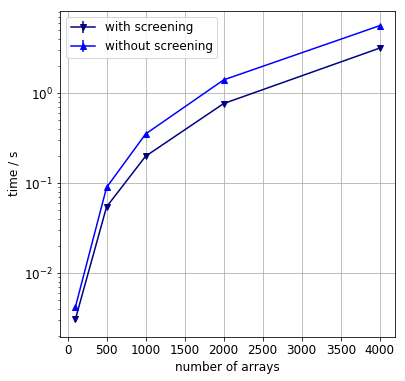

In [36]:
# TO SKIP -- plot setup

res_df1 = pd.DataFrame(results1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

ax.errorbar(res_df1['n_arr'], res_df1['loop_opt_tmean'], yerr = res_df1['loop_opttstdev'],
            color = 'navy', marker = 'v', label = 'with screening')

ax.errorbar(res_df1['n_arr'], res_df1['no_loop_opt_tmean'], yerr = res_df1['no_loop_opt_tstdev'],
            color = 'blue', marker = '^', label = 'without screening')

ax.set_yscale("log")
ax.grid(True)
ax.set_xlabel("number of arrays"); ax.set_ylabel("time / s")
ax.legend()
plt.show()

As we can see the loop optimisation results in a speedup by a factor of two. 

## Conclusions

* An efficient algorithm was implemented to calculate the Tversky index. The algorithm screens for non-overlapping sets. The implementation invoked just-in-time compilation to speed up execution.
* We confirmed our previous knowledge that "Premature optimisation of the root of all evil"

## Future plans

Implement the algorithm using an interval tree for efficient screening of overlapping arrays.